<h1> Quantitative Analysis of Price & Daily Returns </h1>

<ul>
    <li> Can returns be described with a normal distribution? </li>
    <li> Is there directional bias in daily change? </li>
    <li> Can price movement be described as a random walk? </li>
</ul>

<h3> 1. Setting up the environment </h3>

In [4]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import yfinance as fin
import datetime as dt
import quandl as qdl
import matplotlib.pyplot as plt
import os
from scipy import stats
from scipy.stats import norm
from matplotlib import rcParams as rcp
rcp['figure.figsize'] = 8, 6
import seaborn as sb
sb.set()

<h3> 2. Download stock price data, store in dataframe </h3>

In [29]:
start_date = dt.datetime(2012,5,18)
end_date = dt.datetime(2023,1,10)
symbols = ['NVDA', 'VWDRY', 'OLED', 'TSM', 'SONO', 'PAG', 'MDT', 'LLY', 'GLNCY', 'GVDNY', 'EMR', 'EBAY', 'CRWD', 'COO',
          'STZ', 'CMSQY', 'CTSH', 'CB', 'CF', 'BF.B', 'BK', 'ASML', 'AMGN', 'ALSN', 'EADSY', 'ADDYY', 'SPCE', 'LCID', 'BMBL', 'SNAP',
          'AAPL', 'TSLA', 'NFLX', 'META', 'MSFT', 'DIS', 'GPRO', 'SBUX', 'F', 'BABA', 'BAC', 'GE', 'AMZN']

ticker = fin.Ticker(symbols[0])
ticker_hist = ticker.history(start = start_date, end = end_date)

<h3> 3. Viewing Data </h3>

In [30]:
ticker_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-05-18 00:00:00-04:00,2.909275,2.923041,2.757846,2.771612,56728800,0.0,0.0
2012-05-21 00:00:00-04:00,2.776201,2.833560,2.757846,2.819794,41626000,0.0,0.0
2012-05-22 00:00:00-04:00,2.817500,2.822089,2.744080,2.785378,41014000,0.0,0.0
2012-05-23 00:00:00-04:00,2.755551,2.858798,2.714252,2.854209,49600000,0.0,0.0
2012-05-24 00:00:00-04:00,2.870271,2.874859,2.757846,2.778495,52042000,0.0,0.0


<h3> 4. Store instantaneous rate of return in separate series </h3>

In [31]:
tick_close = ticker_hist['Close']
tick_ret = pd.DataFrame(round(np.log(tick_close).diff() * 100, 2))
tick_ret.dropna(inplace = True)
tick_ret.head()

,Close
Date,
2012-05-21 00:00:00-04:00,1.72
2012-05-22 00:00:00-04:00,-1.23
2012-05-23 00:00:00-04:00,2.44
2012-05-24 00:00:00-04:00,-2.69
2012-05-25 00:00:00-04:00,2.37


<h3> 5. Plot the series </h3>

<AxesSubplot: xlabel='Date'>

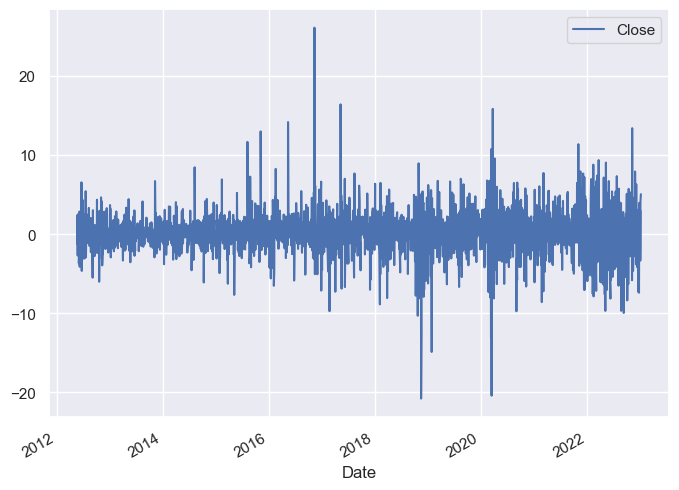

In [32]:
tick_ret.plot()

<h3> 6. Describing function using descreptive statistics, default assumes we are dealing with a sample Pandas also deals with missing vallues by omitting them </h3>

In [33]:
tick_ret.describe()

,Close
count,2677.000000
mean,0.150616
std,2.743327
min,-20.770000
25%,-1.100000
50%,0.180000
75%,1.460000
max,26.090000


<h3> 7. An alternative table of descriptives from scipy stats </h3>

In [34]:
n, minmax, mean, var, skew, kurt = stats.describe(tick_ret)
mini, maxi = minmax
std = np.sqrt(var)

<ul>
    <li> Looking just a the skewness we see a suggested tilt towards the left. </li>
</ul>

<h3> 8. For comparison we generate random numbers that follow normal distribution </h3>

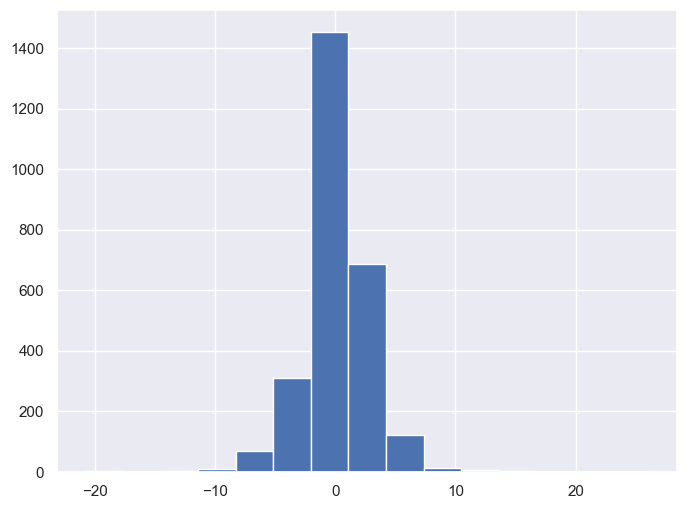

In [35]:
plt.hist(tick_ret, bins = 15);

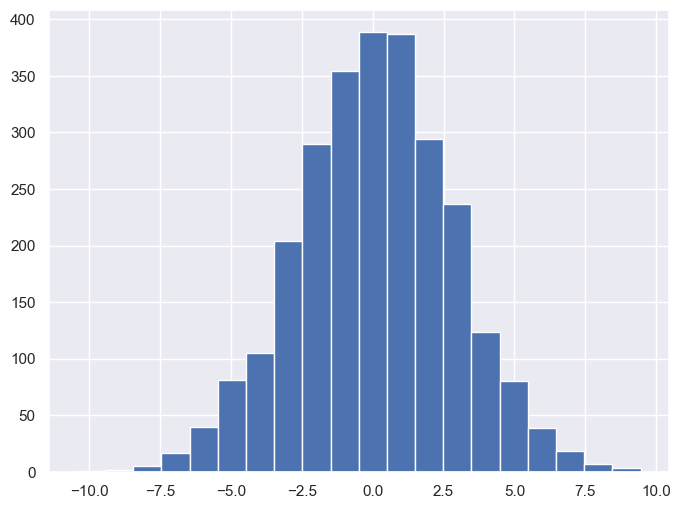

In [36]:
x = norm.rvs(mean, std, n)
plt.hist(x, bins = 20);

<h2> Is price change normally distributed? </h2>

<h3> 9. Testing Kurtosis </h3>
<ul> 
    <li> Null Hypothesis: Sample is drawn from a population where where the underlying kurtosis is that of a normally distributed variable </li>
    <li> Alternate Hypothesis: Sample is not drawn from a population where where the underlying kurtosis is that of a normally distributed variable </li>
</ul>

In [37]:
x_test = stats.kurtosistest(x)
tick_ret1 = round(np.log(tick_close).diff() * 100, 2)
tick_ret1.dropna(inplace = True)
tick_test = stats.kurtosistest(tick_ret1)
print(f'{"      Test statistic":20}{"p-value": >15}')
print(f'{" "*5}{"-"* 30}')
print(f"x:{x_test[0]:>17.2f}{x_test[1]:16.4f}")
print(f"META: {tick_test[0]:13.2f}{tick_test[1]:16.4f}")


      Test statistic        p-value
     ------------------------------
x:             0.86          0.3911
META:         20.61          0.0000


<h3> 10. Plot histogram of Price changes with Normal Curve overlay </h3>

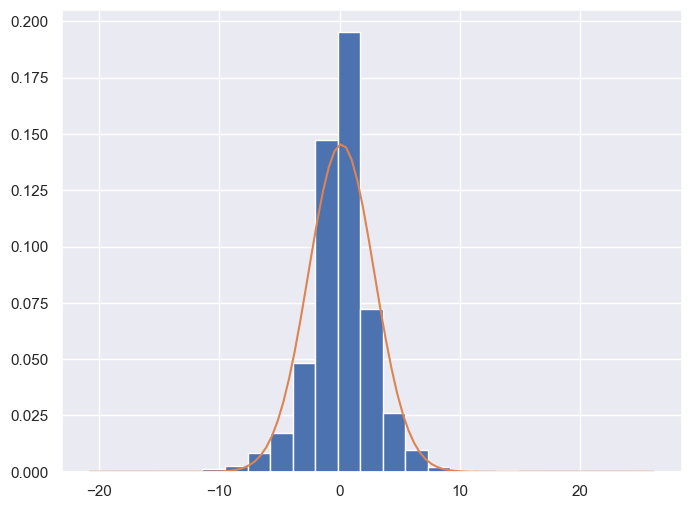

In [38]:
plt.hist(tick_ret,bins = 25, edgecolor = 'w', density = True)
overlay = np.linspace(mini,maxi,100)
plt.plot(overlay, norm.pdf(overlay, mean, std))

<h2> Is daily price change significantly different from zero? </h2>

<h3> 11. Conduct simple hypothesis test </h3>

In [39]:
stats.ttest_1samp(tick_ret1,0,alternative = 'two-sided')

Ttest_1sampResult(statistic=2.84065667592583, pvalue=0.004536112650851083)

<ul>
    <li> Null hypothesis can be rejected as the P-value is less than 0.5. </li>
</ul>

<i> As the sample is too large for the T-test we make the sample smaller and take a sample of one year. </i>

In [40]:
stats.ttest_1samp(tick_ret1.sample(252),0,alternative = 'two-sided')

Ttest_1sampResult(statistic=1.909553204283917, pvalue=0.05733081570714618)

<h2> Can price movement be described as a random walk? </h2>

<h3> 12. Creating price lags </h3>

In [41]:
tick_close = pd.DataFrame(tick_close, columns = ['Close'])
tick_close['lag_1'] = tick_close.Close.shift(1)
tick_close['lag_2'] = tick_close.Close.shift(2)
tick_close.dropna(inplace = True)
tick_close.head()

,Close,lag_1,lag_2
Date,,,
2012-05-22 00:00:00-04:00,2.785378,2.819794,2.771612
2012-05-23 00:00:00-04:00,2.854209,2.785378,2.819794
2012-05-24 00:00:00-04:00,2.778495,2.854209,2.785378
2012-05-25 00:00:00-04:00,2.845032,2.778495,2.854209
2012-05-29 00:00:00-04:00,2.918453,2.845032,2.778495


<h3> 13. Fit Linear Model </h3>

In [42]:
lr = np.linalg.lstsq(tick_close[['lag_1', 'lag_2']], tick_close['Close'], rcond = None)[0]
lr

array([0.95496448, 0.04500047])

In [43]:
tick_close['Predict'] = np.dot(tick_close[['lag_1', 'lag_2']], lr)
tick_close.head()

,Close,lag_1,lag_2,Predict
Date,,,,
2012-05-22 00:00:00-04:00,2.785378,2.819794,2.771612,2.817527
2012-05-23 00:00:00-04:00,2.854209,2.785378,2.819794,2.786830
2012-05-24 00:00:00-04:00,2.778495,2.854209,2.785378,2.851012
2012-05-25 00:00:00-04:00,2.845032,2.778495,2.854209,2.781805
2012-05-29 00:00:00-04:00,2.918453,2.845032,2.778495,2.841938


<h3> 14. Visualizing the Close Price and Predicted Price </h3>

<AxesSubplot: xlabel='Date'>

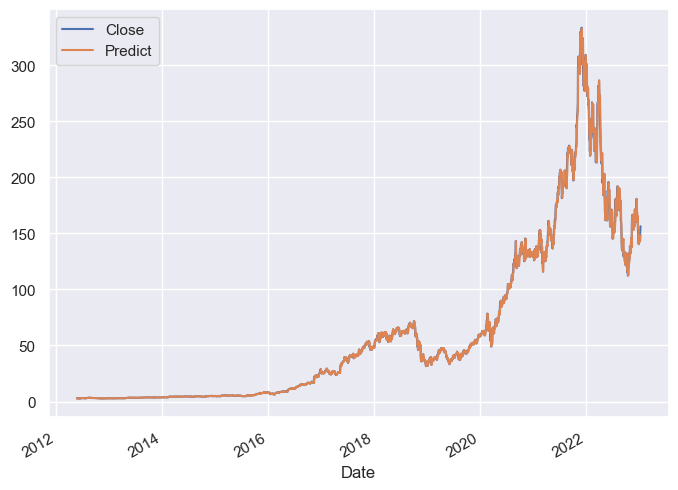

In [44]:
tick_close[['Close', 'Predict']].plot()

<AxesSubplot: xlabel='Date'>

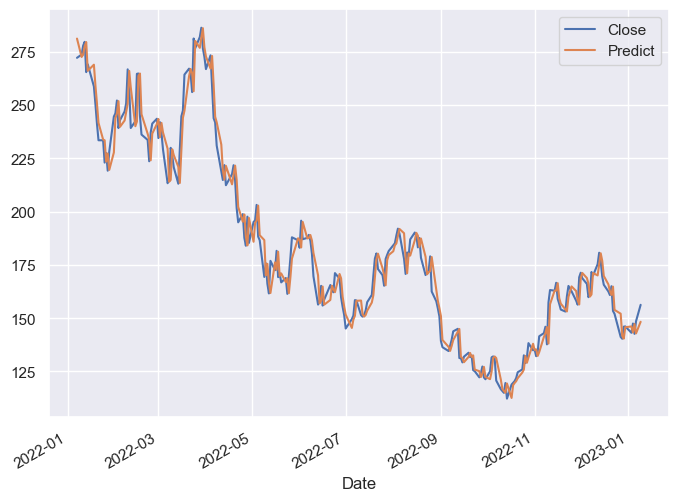

In [45]:
tick_close.iloc[-252:][['Close', 'Predict']].plot()